# Week 3 Analysis Notebook

Goal now is to work towards combining output from last two weeks into making a prediction for the observed cosmic SED. Essentially means accouting for fact that higher $z$ galaxies will be dimmer. Aiming to do this through a lightcone using Chris Lovell's lightcone generation code for SIMBA. Then finally sum the apparent magnitudes as is already being done to get total SED.

In [1]:
from pathlib import Path
import re
import numpy as np
import h5py

import os
os.environ['SPS_HOME'] = '/home/spujni/fsps'
import fsps

import caesar
import astropy.units as u
from astropy.constants import c
import matplotlib.pyplot as plt

import sys
# sys.path.insert(0, '../src')
# from week_2_funcs import get_redshift, list_snapshots, compute_summed_sed_from_appmags, compute_summed_sed_from_absmags, get_stellar_mass_bins, classify_galaxies
lightcone_path = Path('../src/lightcone').resolve()
sys.path.insert(0, str(lightcone_path.parent))
from lightcone.generate_lightcone import generate_lightcone, OUTPUT_DIR


CAT_DIR = Path("/home/spujni/sim/m50n512/s50/Groups/")

yt : [INFO     ] 2026-01-31 15:02:50,333 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_151.hdf5
yt : [INFO     ] 2026-01-31 15:02:51,001 Found 58101 halos
yt : [INFO     ] 2026-01-31 15:02:51,454 Found 6922 galaxies
yt : [INFO     ] 2026-01-31 15:02:51,464 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_150.hdf5
yt : [INFO     ] 2026-01-31 15:02:52,009 Found 58084 halos
yt : [INFO     ] 2026-01-31 15:02:52,551 Found 6892 galaxies
yt : [INFO     ] 2026-01-31 15:02:52,568 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_149.hdf5
yt : [INFO     ] 2026-01-31 15:02:53,175 Found 58509 halos
yt : [INFO     ] 2026-01-31 15:02:53,787 Found 6833 galaxies
yt : [INFO     ] 2026-01-31 15:02:53,803 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_148.hdf5
yt : [INFO     ] 2026-01-31 15:02:54,399 Found 58598 halos
yt : [INFO     ] 2026-01-31 15:02:55,201 Found 6809 galaxies
yt : [INFO     ] 2026-01-31 15:02:55,221 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_147.hdf5
yt : [INFO

Skipping snap 7 (no halo data)
Skipping snap 6 (no halo data)
Skipping snap 5 (no halo data)
Skipping snap 4 (no halo data)
Skipping snap 3 (no halo data)
Skipping snap 2 (no halo data)


yt : [INFO     ] 2026-01-31 15:05:11,820 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_151.hdf5
yt : [INFO     ] 2026-01-31 15:05:11,847 Found 58101 halos
yt : [INFO     ] 2026-01-31 15:05:11,857 Found 6922 galaxies


Skipping snap 1 (no halo data)

Using 128 snapshots
Redshift range: 0.00 to 8.48

Processing snap 151, z=0.000


yt : [INFO     ] 2026-01-31 15:05:12,240 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_150.hdf5
yt : [INFO     ] 2026-01-31 15:05:12,250 Found 58084 halos
yt : [INFO     ] 2026-01-31 15:05:12,254 Found 6892 galaxies


  Selected 0 of 6922 galaxies

Processing snap 150, z=0.017


yt : [INFO     ] 2026-01-31 15:05:12,642 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_149.hdf5
yt : [INFO     ] 2026-01-31 15:05:12,652 Found 58509 halos
yt : [INFO     ] 2026-01-31 15:05:12,657 Found 6833 galaxies


  Selected 2 of 6892 galaxies

Processing snap 149, z=0.034


yt : [INFO     ] 2026-01-31 15:05:12,879 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_148.hdf5
yt : [INFO     ] 2026-01-31 15:05:12,889 Found 58598 halos
yt : [INFO     ] 2026-01-31 15:05:12,895 Found 6809 galaxies


  Selected 9 of 6833 galaxies

Processing snap 148, z=0.051


yt : [INFO     ] 2026-01-31 15:05:13,313 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_147.hdf5
yt : [INFO     ] 2026-01-31 15:05:13,324 Found 58693 halos
yt : [INFO     ] 2026-01-31 15:05:13,328 Found 6692 galaxies


  Selected 13 of 6809 galaxies

Processing snap 147, z=0.068


yt : [INFO     ] 2026-01-31 15:05:13,715 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_146.hdf5
yt : [INFO     ] 2026-01-31 15:05:13,725 Found 58750 halos
yt : [INFO     ] 2026-01-31 15:05:13,729 Found 6709 galaxies


  Selected 4 of 6692 galaxies

Processing snap 146, z=0.085


yt : [INFO     ] 2026-01-31 15:05:14,123 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_145.hdf5
yt : [INFO     ] 2026-01-31 15:05:14,134 Found 58755 halos
yt : [INFO     ] 2026-01-31 15:05:14,138 Found 6594 galaxies


  Selected 98 of 6709 galaxies

Processing snap 145, z=0.102
  Selected 225 of 6594 galaxies


yt : [INFO     ] 2026-01-31 15:05:14,904 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_144.hdf5
yt : [INFO     ] 2026-01-31 15:05:14,914 Found 58885 halos
yt : [INFO     ] 2026-01-31 15:05:14,919 Found 6558 galaxies



Processing snap 144, z=0.120
  Selected 140 of 6558 galaxies


yt : [INFO     ] 2026-01-31 15:05:15,347 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_143.hdf5
yt : [INFO     ] 2026-01-31 15:05:15,357 Found 59035 halos
yt : [INFO     ] 2026-01-31 15:05:15,362 Found 6533 galaxies



Processing snap 143, z=0.138
  Selected 136 of 6533 galaxies


yt : [INFO     ] 2026-01-31 15:05:15,848 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_142.hdf5
yt : [INFO     ] 2026-01-31 15:05:15,859 Found 59000 halos
yt : [INFO     ] 2026-01-31 15:05:15,865 Found 6506 galaxies



Processing snap 142, z=0.156


yt : [INFO     ] 2026-01-31 15:05:16,312 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_141.hdf5
yt : [INFO     ] 2026-01-31 15:05:16,322 Found 59089 halos
yt : [INFO     ] 2026-01-31 15:05:16,328 Found 6426 galaxies


  Selected 13 of 6506 galaxies

Processing snap 141, z=0.174


yt : [INFO     ] 2026-01-31 15:05:16,655 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_140.hdf5
yt : [INFO     ] 2026-01-31 15:05:16,665 Found 59331 halos
yt : [INFO     ] 2026-01-31 15:05:16,670 Found 6374 galaxies


  Selected 98 of 6426 galaxies

Processing snap 140, z=0.192
  Selected 359 of 6374 galaxies


yt : [INFO     ] 2026-01-31 15:05:17,468 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_139.hdf5
yt : [INFO     ] 2026-01-31 15:05:17,482 Found 59360 halos
yt : [INFO     ] 2026-01-31 15:05:17,487 Found 6370 galaxies



Processing snap 139, z=0.210


yt : [INFO     ] 2026-01-31 15:05:18,094 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_138.hdf5
yt : [INFO     ] 2026-01-31 15:05:18,104 Found 59489 halos
yt : [INFO     ] 2026-01-31 15:05:18,109 Found 6336 galaxies


  Selected 73 of 6370 galaxies

Processing snap 138, z=0.229


yt : [INFO     ] 2026-01-31 15:05:18,393 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_137.hdf5
yt : [INFO     ] 2026-01-31 15:05:18,404 Found 59731 halos
yt : [INFO     ] 2026-01-31 15:05:18,409 Found 6265 galaxies


  Selected 73 of 6336 galaxies

Processing snap 137, z=0.248
  Selected 573 of 6265 galaxies


yt : [INFO     ] 2026-01-31 15:05:19,481 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_136.hdf5
yt : [INFO     ] 2026-01-31 15:05:19,492 Found 60033 halos
yt : [INFO     ] 2026-01-31 15:05:19,497 Found 6196 galaxies



Processing snap 136, z=0.267
  Selected 359 of 6196 galaxies


yt : [INFO     ] 2026-01-31 15:05:20,277 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_135.hdf5
yt : [INFO     ] 2026-01-31 15:05:20,287 Found 60182 halos
yt : [INFO     ] 2026-01-31 15:05:20,292 Found 6180 galaxies



Processing snap 135, z=0.286
  Selected 175 of 6180 galaxies


yt : [INFO     ] 2026-01-31 15:05:21,043 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_134.hdf5
yt : [INFO     ] 2026-01-31 15:05:21,054 Found 60233 halos
yt : [INFO     ] 2026-01-31 15:05:21,059 Found 6137 galaxies



Processing snap 134, z=0.305
  Selected 1052 of 6137 galaxies


yt : [INFO     ] 2026-01-31 15:05:22,870 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_133.hdf5
yt : [INFO     ] 2026-01-31 15:05:22,881 Found 60540 halos
yt : [INFO     ] 2026-01-31 15:05:22,886 Found 6114 galaxies



Processing snap 133, z=0.325
  Selected 109 of 6114 galaxies


yt : [INFO     ] 2026-01-31 15:05:23,230 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_132.hdf5
yt : [INFO     ] 2026-01-31 15:05:23,240 Found 60622 halos
yt : [INFO     ] 2026-01-31 15:05:23,245 Found 6035 galaxies



Processing snap 132, z=0.345
  Selected 1323 of 6035 galaxies


yt : [INFO     ] 2026-01-31 15:05:25,665 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_131.hdf5
yt : [INFO     ] 2026-01-31 15:05:25,676 Found 60736 halos
yt : [INFO     ] 2026-01-31 15:05:25,681 Found 5964 galaxies



Processing snap 131, z=0.365
  Selected 1060 of 5964 galaxies


yt : [INFO     ] 2026-01-31 15:05:27,486 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_130.hdf5
yt : [INFO     ] 2026-01-31 15:05:27,497 Found 60969 halos
yt : [INFO     ] 2026-01-31 15:05:27,502 Found 5960 galaxies



Processing snap 130, z=0.385
  Selected 999 of 5960 galaxies


yt : [INFO     ] 2026-01-31 15:05:29,216 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_129.hdf5
yt : [INFO     ] 2026-01-31 15:05:29,224 Found 61119 halos
yt : [INFO     ] 2026-01-31 15:05:29,227 Found 5904 galaxies



Processing snap 129, z=0.406
  Selected 1448 of 5904 galaxies


yt : [INFO     ] 2026-01-31 15:05:31,251 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_128.hdf5
yt : [INFO     ] 2026-01-31 15:05:31,259 Found 61148 halos
yt : [INFO     ] 2026-01-31 15:05:31,262 Found 5809 galaxies



Processing snap 128, z=0.427
  Selected 1301 of 5809 galaxies


yt : [INFO     ] 2026-01-31 15:05:33,081 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_127.hdf5
yt : [INFO     ] 2026-01-31 15:05:33,088 Found 61506 halos
yt : [INFO     ] 2026-01-31 15:05:33,092 Found 5753 galaxies



Processing snap 127, z=0.448
  Selected 856 of 5753 galaxies


yt : [INFO     ] 2026-01-31 15:05:34,311 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_126.hdf5
yt : [INFO     ] 2026-01-31 15:05:34,318 Found 61687 halos
yt : [INFO     ] 2026-01-31 15:05:34,322 Found 5288 galaxies



Processing snap 126, z=0.469
  Selected 1716 of 5288 galaxies


yt : [INFO     ] 2026-01-31 15:05:36,726 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_125.hdf5
yt : [INFO     ] 2026-01-31 15:05:36,735 Found 61977 halos
yt : [INFO     ] 2026-01-31 15:05:36,739 Found 5685 galaxies



Processing snap 125, z=0.490
  Selected 466 of 5685 galaxies


yt : [INFO     ] 2026-01-31 15:05:37,588 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_124.hdf5
yt : [INFO     ] 2026-01-31 15:05:37,596 Found 62034 halos
yt : [INFO     ] 2026-01-31 15:05:37,599 Found 5630 galaxies



Processing snap 124, z=0.512
  Selected 724 of 5630 galaxies


yt : [INFO     ] 2026-01-31 15:05:38,707 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_123.hdf5
yt : [INFO     ] 2026-01-31 15:05:38,714 Found 62325 halos
yt : [INFO     ] 2026-01-31 15:05:38,718 Found 5589 galaxies



Processing snap 123, z=0.534
  Selected 475 of 5589 galaxies


yt : [INFO     ] 2026-01-31 15:05:39,824 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_122.hdf5
yt : [INFO     ] 2026-01-31 15:05:39,832 Found 62620 halos
yt : [INFO     ] 2026-01-31 15:05:39,835 Found 5529 galaxies



Processing snap 122, z=0.557
  Selected 1123 of 5529 galaxies


yt : [INFO     ] 2026-01-31 15:05:41,446 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_121.hdf5
yt : [INFO     ] 2026-01-31 15:05:41,454 Found 62801 halos
yt : [INFO     ] 2026-01-31 15:05:41,457 Found 5496 galaxies



Processing snap 121, z=0.580
  Selected 2118 of 5496 galaxies


yt : [INFO     ] 2026-01-31 15:05:44,417 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_120.hdf5
yt : [INFO     ] 2026-01-31 15:05:44,425 Found 62959 halos
yt : [INFO     ] 2026-01-31 15:05:44,429 Found 5475 galaxies



Processing snap 120, z=0.603
  Selected 3455 of 5475 galaxies


yt : [INFO     ] 2026-01-31 15:05:48,863 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_119.hdf5
yt : [INFO     ] 2026-01-31 15:05:48,871 Found 63137 halos
yt : [INFO     ] 2026-01-31 15:05:48,875 Found 5395 galaxies



Processing snap 119, z=0.626
  Selected 644 of 5395 galaxies


yt : [INFO     ] 2026-01-31 15:05:49,808 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_118.hdf5
yt : [INFO     ] 2026-01-31 15:05:49,816 Found 63328 halos
yt : [INFO     ] 2026-01-31 15:05:49,819 Found 5365 galaxies



Processing snap 118, z=0.650
  Selected 1912 of 5365 galaxies


yt : [INFO     ] 2026-01-31 15:05:52,403 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_117.hdf5
yt : [INFO     ] 2026-01-31 15:05:52,411 Found 63374 halos
yt : [INFO     ] 2026-01-31 15:05:52,415 Found 5330 galaxies



Processing snap 117, z=0.674
  Selected 2193 of 5330 galaxies


yt : [INFO     ] 2026-01-31 15:05:55,275 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_116.hdf5
yt : [INFO     ] 2026-01-31 15:05:55,283 Found 63700 halos
yt : [INFO     ] 2026-01-31 15:05:55,286 Found 5283 galaxies



Processing snap 116, z=0.698
  Selected 2270 of 5283 galaxies


yt : [INFO     ] 2026-01-31 15:05:58,334 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_115.hdf5
yt : [INFO     ] 2026-01-31 15:05:58,342 Found 63934 halos
yt : [INFO     ] 2026-01-31 15:05:58,345 Found 5246 galaxies



Processing snap 115, z=0.723
  Selected 3739 of 5246 galaxies


yt : [INFO     ] 2026-01-31 15:06:03,147 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_114.hdf5
yt : [INFO     ] 2026-01-31 15:06:03,155 Found 64025 halos
yt : [INFO     ] 2026-01-31 15:06:03,158 Found 5220 galaxies



Processing snap 114, z=0.748
  Selected 1933 of 5220 galaxies


yt : [INFO     ] 2026-01-31 15:06:06,201 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_113.hdf5
yt : [INFO     ] 2026-01-31 15:06:06,209 Found 64060 halos
yt : [INFO     ] 2026-01-31 15:06:06,212 Found 5188 galaxies



Processing snap 113, z=0.773
  Selected 4137 of 5188 galaxies


yt : [INFO     ] 2026-01-31 15:06:11,529 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_112.hdf5
yt : [INFO     ] 2026-01-31 15:06:11,537 Found 64359 halos
yt : [INFO     ] 2026-01-31 15:06:11,541 Found 5134 galaxies



Processing snap 112, z=0.799
  Selected 1883 of 5134 galaxies


yt : [INFO     ] 2026-01-31 15:06:13,961 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_111.hdf5
yt : [INFO     ] 2026-01-31 15:06:13,969 Found 64569 halos
yt : [INFO     ] 2026-01-31 15:06:13,973 Found 5139 galaxies



Processing snap 111, z=0.826
  Selected 3176 of 5139 galaxies


yt : [INFO     ] 2026-01-31 15:06:17,895 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_110.hdf5
yt : [INFO     ] 2026-01-31 15:06:17,903 Found 64796 halos
yt : [INFO     ] 2026-01-31 15:06:17,906 Found 5111 galaxies



Processing snap 110, z=0.852
  Selected 2434 of 5111 galaxies


yt : [INFO     ] 2026-01-31 15:06:21,067 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_109.hdf5
yt : [INFO     ] 2026-01-31 15:06:21,076 Found 64861 halos
yt : [INFO     ] 2026-01-31 15:06:21,080 Found 5065 galaxies



Processing snap 109, z=0.880
  Selected 3132 of 5065 galaxies


yt : [INFO     ] 2026-01-31 15:06:25,089 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_108.hdf5
yt : [INFO     ] 2026-01-31 15:06:25,097 Found 65067 halos
yt : [INFO     ] 2026-01-31 15:06:25,100 Found 5062 galaxies



Processing snap 108, z=0.907
  Selected 4559 of 5062 galaxies


yt : [INFO     ] 2026-01-31 15:06:31,064 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_107.hdf5
yt : [INFO     ] 2026-01-31 15:06:31,072 Found 65302 halos
yt : [INFO     ] 2026-01-31 15:06:31,075 Found 5012 galaxies



Processing snap 107, z=0.935
  Selected 4123 of 5012 galaxies


yt : [INFO     ] 2026-01-31 15:06:36,448 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_106.hdf5
yt : [INFO     ] 2026-01-31 15:06:36,456 Found 65728 halos
yt : [INFO     ] 2026-01-31 15:06:36,460 Found 4947 galaxies



Processing snap 106, z=0.964
  Selected 2273 of 4947 galaxies


yt : [INFO     ] 2026-01-31 15:06:39,321 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_105.hdf5
yt : [INFO     ] 2026-01-31 15:06:39,329 Found 65993 halos
yt : [INFO     ] 2026-01-31 15:06:39,332 Found 4931 galaxies



Processing snap 105, z=0.993
  Selected 2331 of 4931 galaxies


yt : [INFO     ] 2026-01-31 15:06:42,279 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_104.hdf5
yt : [INFO     ] 2026-01-31 15:06:42,287 Found 66167 halos
yt : [INFO     ] 2026-01-31 15:06:42,291 Found 4868 galaxies



Processing snap 104, z=1.022
  Selected 3926 of 4868 galaxies


yt : [INFO     ] 2026-01-31 15:06:47,083 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_103.hdf5
yt : [INFO     ] 2026-01-31 15:06:47,092 Found 66452 halos
yt : [INFO     ] 2026-01-31 15:06:47,096 Found 4822 galaxies



Processing snap 103, z=1.052
  Selected 3397 of 4822 galaxies


yt : [INFO     ] 2026-01-31 15:06:51,400 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_102.hdf5
yt : [INFO     ] 2026-01-31 15:06:51,408 Found 66456 halos
yt : [INFO     ] 2026-01-31 15:06:51,412 Found 4793 galaxies



Processing snap 102, z=1.083
  Selected 4128 of 4793 galaxies


yt : [INFO     ] 2026-01-31 15:06:56,530 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_101.hdf5
yt : [INFO     ] 2026-01-31 15:06:56,538 Found 66675 halos
yt : [INFO     ] 2026-01-31 15:06:56,542 Found 4748 galaxies



Processing snap 101, z=1.114
  Selected 3370 of 4748 galaxies


yt : [INFO     ] 2026-01-31 15:07:01,269 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_100.hdf5
yt : [INFO     ] 2026-01-31 15:07:01,277 Found 66852 halos
yt : [INFO     ] 2026-01-31 15:07:01,281 Found 4730 galaxies



Processing snap 100, z=1.145
  Selected 4465 of 4730 galaxies


yt : [INFO     ] 2026-01-31 15:07:06,952 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_099.hdf5
yt : [INFO     ] 2026-01-31 15:07:06,960 Found 66912 halos
yt : [INFO     ] 2026-01-31 15:07:06,963 Found 4669 galaxies



Processing snap 99, z=1.178
  Selected 4194 of 4669 galaxies


yt : [INFO     ] 2026-01-31 15:07:12,273 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_098.hdf5
yt : [INFO     ] 2026-01-31 15:07:12,281 Found 67022 halos
yt : [INFO     ] 2026-01-31 15:07:12,285 Found 4668 galaxies



Processing snap 98, z=1.211
  Selected 4090 of 4668 galaxies


yt : [INFO     ] 2026-01-31 15:07:17,467 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_097.hdf5
yt : [INFO     ] 2026-01-31 15:07:17,475 Found 67248 halos
yt : [INFO     ] 2026-01-31 15:07:17,478 Found 4608 galaxies



Processing snap 97, z=1.244
  Selected 4334 of 4608 galaxies


yt : [INFO     ] 2026-01-31 15:07:22,921 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_096.hdf5
yt : [INFO     ] 2026-01-31 15:07:22,929 Found 67290 halos
yt : [INFO     ] 2026-01-31 15:07:22,933 Found 4599 galaxies



Processing snap 96, z=1.278
  Selected 4348 of 4599 galaxies


yt : [INFO     ] 2026-01-31 15:07:28,468 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_095.hdf5
yt : [INFO     ] 2026-01-31 15:07:28,476 Found 67525 halos
yt : [INFO     ] 2026-01-31 15:07:28,479 Found 4558 galaxies



Processing snap 95, z=1.313
  Selected 4491 of 4558 galaxies


yt : [INFO     ] 2026-01-31 15:07:34,203 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_094.hdf5
yt : [INFO     ] 2026-01-31 15:07:34,210 Found 67596 halos
yt : [INFO     ] 2026-01-31 15:07:34,214 Found 4487 galaxies



Processing snap 94, z=1.348
  Selected 4472 of 4487 galaxies


yt : [INFO     ] 2026-01-31 15:07:39,932 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_093.hdf5
yt : [INFO     ] 2026-01-31 15:07:39,940 Found 67742 halos
yt : [INFO     ] 2026-01-31 15:07:39,944 Found 4460 galaxies



Processing snap 93, z=1.384
  Selected 4460 of 4460 galaxies


yt : [INFO     ] 2026-01-31 15:07:46,245 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_092.hdf5
yt : [INFO     ] 2026-01-31 15:07:46,254 Found 67922 halos
yt : [INFO     ] 2026-01-31 15:07:46,258 Found 4389 galaxies



Processing snap 92, z=1.421
  Selected 4389 of 4389 galaxies


yt : [INFO     ] 2026-01-31 15:07:51,784 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_091.hdf5
yt : [INFO     ] 2026-01-31 15:07:51,792 Found 68001 halos
yt : [INFO     ] 2026-01-31 15:07:51,795 Found 4391 galaxies



Processing snap 91, z=1.458
  Selected 4391 of 4391 galaxies


yt : [INFO     ] 2026-01-31 15:07:57,360 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_090.hdf5
yt : [INFO     ] 2026-01-31 15:07:57,368 Found 68131 halos
yt : [INFO     ] 2026-01-31 15:07:57,372 Found 4345 galaxies



Processing snap 90, z=1.497
  Selected 4345 of 4345 galaxies


yt : [INFO     ] 2026-01-31 15:08:02,749 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_089.hdf5
yt : [INFO     ] 2026-01-31 15:08:02,758 Found 68160 halos
yt : [INFO     ] 2026-01-31 15:08:02,762 Found 4294 galaxies



Processing snap 89, z=1.536
  Selected 4294 of 4294 galaxies


yt : [INFO     ] 2026-01-31 15:08:08,183 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_088.hdf5
yt : [INFO     ] 2026-01-31 15:08:08,191 Found 68146 halos
yt : [INFO     ] 2026-01-31 15:08:08,195 Found 4265 galaxies



Processing snap 88, z=1.576
  Selected 4265 of 4265 galaxies


yt : [INFO     ] 2026-01-31 15:08:13,426 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_087.hdf5
yt : [INFO     ] 2026-01-31 15:08:13,434 Found 68109 halos
yt : [INFO     ] 2026-01-31 15:08:13,437 Found 4219 galaxies



Processing snap 87, z=1.616
  Selected 4219 of 4219 galaxies


yt : [INFO     ] 2026-01-31 15:08:18,500 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_086.hdf5
yt : [INFO     ] 2026-01-31 15:08:18,509 Found 68069 halos
yt : [INFO     ] 2026-01-31 15:08:18,512 Found 4193 galaxies



Processing snap 86, z=1.658
  Selected 4193 of 4193 galaxies


yt : [INFO     ] 2026-01-31 15:08:23,688 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_085.hdf5
yt : [INFO     ] 2026-01-31 15:08:23,696 Found 68057 halos
yt : [INFO     ] 2026-01-31 15:08:23,699 Found 4130 galaxies



Processing snap 85, z=1.700
  Selected 4130 of 4130 galaxies


yt : [INFO     ] 2026-01-31 15:08:28,914 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_084.hdf5
yt : [INFO     ] 2026-01-31 15:08:28,922 Found 64333 halos
yt : [INFO     ] 2026-01-31 15:08:28,924 Found 4053 galaxies



Processing snap 84, z=1.744
  Selected 4053 of 4053 galaxies


yt : [INFO     ] 2026-01-31 15:08:34,748 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_083.hdf5
yt : [INFO     ] 2026-01-31 15:08:34,756 Found 68029 halos
yt : [INFO     ] 2026-01-31 15:08:34,759 Found 4057 galaxies



Processing snap 83, z=1.788
  Selected 4057 of 4057 galaxies


yt : [INFO     ] 2026-01-31 15:08:39,812 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_082.hdf5
yt : [INFO     ] 2026-01-31 15:08:39,821 Found 68170 halos
yt : [INFO     ] 2026-01-31 15:08:39,824 Found 4018 galaxies



Processing snap 82, z=1.833
  Selected 4018 of 4018 galaxies


yt : [INFO     ] 2026-01-31 15:08:44,915 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_081.hdf5
yt : [INFO     ] 2026-01-31 15:08:44,923 Found 67889 halos
yt : [INFO     ] 2026-01-31 15:08:44,926 Found 3929 galaxies



Processing snap 81, z=1.879
  Selected 3929 of 3929 galaxies


yt : [INFO     ] 2026-01-31 15:08:49,665 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_080.hdf5
yt : [INFO     ] 2026-01-31 15:08:49,673 Found 68016 halos
yt : [INFO     ] 2026-01-31 15:08:49,677 Found 3908 galaxies



Processing snap 80, z=1.927
  Selected 3908 of 3908 galaxies


yt : [INFO     ] 2026-01-31 15:08:54,611 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_079.hdf5
yt : [INFO     ] 2026-01-31 15:08:54,619 Found 67782 halos
yt : [INFO     ] 2026-01-31 15:08:54,624 Found 3874 galaxies



Processing snap 79, z=1.975
  Selected 3874 of 3874 galaxies


yt : [INFO     ] 2026-01-31 15:08:59,442 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_078.hdf5
yt : [INFO     ] 2026-01-31 15:08:59,450 Found 67682 halos
yt : [INFO     ] 2026-01-31 15:08:59,453 Found 3814 galaxies



Processing snap 78, z=2.025
  Selected 3814 of 3814 galaxies


yt : [INFO     ] 2026-01-31 15:09:04,279 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_077.hdf5
yt : [INFO     ] 2026-01-31 15:09:04,287 Found 67548 halos
yt : [INFO     ] 2026-01-31 15:09:04,290 Found 3794 galaxies



Processing snap 77, z=2.075
  Selected 3794 of 3794 galaxies


yt : [INFO     ] 2026-01-31 15:09:09,055 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_076.hdf5
yt : [INFO     ] 2026-01-31 15:09:09,064 Found 67390 halos
yt : [INFO     ] 2026-01-31 15:09:09,068 Found 3744 galaxies



Processing snap 76, z=2.127
  Selected 3744 of 3744 galaxies


yt : [INFO     ] 2026-01-31 15:09:13,566 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_075.hdf5
yt : [INFO     ] 2026-01-31 15:09:13,574 Found 67242 halos
yt : [INFO     ] 2026-01-31 15:09:13,578 Found 3717 galaxies



Processing snap 75, z=2.180
  Selected 3717 of 3717 galaxies


yt : [INFO     ] 2026-01-31 15:09:18,148 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_074.hdf5
yt : [INFO     ] 2026-01-31 15:09:18,156 Found 67149 halos
yt : [INFO     ] 2026-01-31 15:09:18,160 Found 3675 galaxies



Processing snap 74, z=2.234
  Selected 3675 of 3675 galaxies


yt : [INFO     ] 2026-01-31 15:09:22,954 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_073.hdf5
yt : [INFO     ] 2026-01-31 15:09:22,962 Found 66946 halos
yt : [INFO     ] 2026-01-31 15:09:22,966 Found 3584 galaxies



Processing snap 73, z=2.290
  Selected 3584 of 3584 galaxies


yt : [INFO     ] 2026-01-31 15:09:27,466 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_072.hdf5
yt : [INFO     ] 2026-01-31 15:09:27,474 Found 66739 halos
yt : [INFO     ] 2026-01-31 15:09:27,478 Found 3560 galaxies



Processing snap 72, z=2.347
  Selected 3560 of 3560 galaxies


yt : [INFO     ] 2026-01-31 15:09:32,055 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_071.hdf5
yt : [INFO     ] 2026-01-31 15:09:32,063 Found 66338 halos
yt : [INFO     ] 2026-01-31 15:09:32,066 Found 3530 galaxies



Processing snap 71, z=2.405
  Selected 3530 of 3530 galaxies


yt : [INFO     ] 2026-01-31 15:09:36,482 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_070.hdf5
yt : [INFO     ] 2026-01-31 15:09:36,490 Found 65914 halos
yt : [INFO     ] 2026-01-31 15:09:36,494 Found 3498 galaxies



Processing snap 70, z=2.465
  Selected 3498 of 3498 galaxies


yt : [INFO     ] 2026-01-31 15:09:41,138 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_069.hdf5
yt : [INFO     ] 2026-01-31 15:09:41,146 Found 65563 halos
yt : [INFO     ] 2026-01-31 15:09:41,150 Found 3454 galaxies



Processing snap 69, z=2.527
  Selected 3454 of 3454 galaxies


yt : [INFO     ] 2026-01-31 15:09:45,699 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_068.hdf5
yt : [INFO     ] 2026-01-31 15:09:45,706 Found 65261 halos
yt : [INFO     ] 2026-01-31 15:09:45,710 Found 3415 galaxies



Processing snap 68, z=2.590
  Selected 3415 of 3415 galaxies


yt : [INFO     ] 2026-01-31 15:09:50,123 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_067.hdf5
yt : [INFO     ] 2026-01-31 15:09:50,131 Found 64743 halos
yt : [INFO     ] 2026-01-31 15:09:50,135 Found 3366 galaxies



Processing snap 67, z=2.654
  Selected 3366 of 3366 galaxies


yt : [INFO     ] 2026-01-31 15:09:54,382 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_066.hdf5
yt : [INFO     ] 2026-01-31 15:09:54,393 Found 64132 halos
yt : [INFO     ] 2026-01-31 15:09:54,397 Found 3351 galaxies



Processing snap 66, z=2.720
  Selected 3351 of 3351 galaxies


yt : [INFO     ] 2026-01-31 15:09:58,723 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_065.hdf5
yt : [INFO     ] 2026-01-31 15:09:58,732 Found 63584 halos
yt : [INFO     ] 2026-01-31 15:09:58,735 Found 3287 galaxies



Processing snap 65, z=2.788
  Selected 3287 of 3287 galaxies


yt : [INFO     ] 2026-01-31 15:10:02,921 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_064.hdf5
yt : [INFO     ] 2026-01-31 15:10:02,929 Found 62958 halos
yt : [INFO     ] 2026-01-31 15:10:02,933 Found 3249 galaxies



Processing snap 64, z=2.858
  Selected 3249 of 3249 galaxies


yt : [INFO     ] 2026-01-31 15:10:07,283 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_063.hdf5
yt : [INFO     ] 2026-01-31 15:10:07,291 Found 62486 halos
yt : [INFO     ] 2026-01-31 15:10:07,295 Found 3180 galaxies



Processing snap 63, z=2.930
  Selected 3180 of 3180 galaxies


yt : [INFO     ] 2026-01-31 15:10:11,407 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_062.hdf5
yt : [INFO     ] 2026-01-31 15:10:11,414 Found 61816 halos
yt : [INFO     ] 2026-01-31 15:10:11,418 Found 3109 galaxies



Processing snap 62, z=3.003
  Selected 3109 of 3109 galaxies


yt : [INFO     ] 2026-01-31 15:10:15,352 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_061.hdf5
yt : [INFO     ] 2026-01-31 15:10:15,360 Found 60973 halos
yt : [INFO     ] 2026-01-31 15:10:15,364 Found 3097 galaxies



Processing snap 61, z=3.079
  Selected 3097 of 3097 galaxies


yt : [INFO     ] 2026-01-31 15:10:19,802 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_060.hdf5
yt : [INFO     ] 2026-01-31 15:10:19,809 Found 60256 halos
yt : [INFO     ] 2026-01-31 15:10:19,813 Found 3065 galaxies



Processing snap 60, z=3.156
  Selected 3065 of 3065 galaxies


yt : [INFO     ] 2026-01-31 15:10:23,817 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_059.hdf5
yt : [INFO     ] 2026-01-31 15:10:23,825 Found 59401 halos
yt : [INFO     ] 2026-01-31 15:10:23,829 Found 3022 galaxies



Processing snap 59, z=3.236
  Selected 3022 of 3022 galaxies


yt : [INFO     ] 2026-01-31 15:10:27,766 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_058.hdf5
yt : [INFO     ] 2026-01-31 15:10:27,774 Found 58558 halos
yt : [INFO     ] 2026-01-31 15:10:27,778 Found 2963 galaxies



Processing snap 58, z=3.318
  Selected 2963 of 2963 galaxies


yt : [INFO     ] 2026-01-31 15:10:31,624 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_057.hdf5
yt : [INFO     ] 2026-01-31 15:10:31,632 Found 57510 halos
yt : [INFO     ] 2026-01-31 15:10:31,635 Found 2898 galaxies



Processing snap 57, z=3.402
  Selected 2898 of 2898 galaxies


yt : [INFO     ] 2026-01-31 15:10:35,483 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_056.hdf5
yt : [INFO     ] 2026-01-31 15:10:35,491 Found 56378 halos



Processing snap 56, z=3.489


yt : [INFO     ] 2026-01-31 15:10:36,360 Found 2873 galaxies


  Selected 2873 of 2873 galaxies


yt : [INFO     ] 2026-01-31 15:10:40,126 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_055.hdf5
yt : [INFO     ] 2026-01-31 15:10:40,134 Found 55418 halos
yt : [INFO     ] 2026-01-31 15:10:40,138 Found 2819 galaxies



Processing snap 55, z=3.579
  Selected 2819 of 2819 galaxies


yt : [INFO     ] 2026-01-31 15:10:43,675 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_054.hdf5
yt : [INFO     ] 2026-01-31 15:10:43,682 Found 54202 halos
yt : [INFO     ] 2026-01-31 15:10:43,686 Found 2710 galaxies



Processing snap 54, z=3.671
  Selected 2710 of 2710 galaxies


yt : [INFO     ] 2026-01-31 15:10:47,111 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_053.hdf5
yt : [INFO     ] 2026-01-31 15:10:47,119 Found 53007 halos
yt : [INFO     ] 2026-01-31 15:10:47,122 Found 2665 galaxies



Processing snap 53, z=3.765
  Selected 2665 of 2665 galaxies


yt : [INFO     ] 2026-01-31 15:10:50,530 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_052.hdf5
yt : [INFO     ] 2026-01-31 15:10:50,537 Found 51717 halos
yt : [INFO     ] 2026-01-31 15:10:50,541 Found 2575 galaxies



Processing snap 52, z=3.863
  Selected 2575 of 2575 galaxies


yt : [INFO     ] 2026-01-31 15:10:53,916 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_051.hdf5
yt : [INFO     ] 2026-01-31 15:10:53,923 Found 50250 halos
yt : [INFO     ] 2026-01-31 15:10:53,927 Found 2505 galaxies



Processing snap 51, z=3.963
  Selected 2505 of 2505 galaxies


yt : [INFO     ] 2026-01-31 15:10:57,074 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_050.hdf5
yt : [INFO     ] 2026-01-31 15:10:57,082 Found 48604 halos
yt : [INFO     ] 2026-01-31 15:10:57,086 Found 2379 galaxies



Processing snap 50, z=4.067
  Selected 2379 of 2379 galaxies


yt : [INFO     ] 2026-01-31 15:11:00,133 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_049.hdf5
yt : [INFO     ] 2026-01-31 15:11:00,141 Found 47199 halos
yt : [INFO     ] 2026-01-31 15:11:00,144 Found 2272 galaxies



Processing snap 49, z=4.174
  Selected 2272 of 2272 galaxies


yt : [INFO     ] 2026-01-31 15:11:03,027 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_048.hdf5
yt : [INFO     ] 2026-01-31 15:11:03,035 Found 45557 halos
yt : [INFO     ] 2026-01-31 15:11:03,039 Found 2178 galaxies



Processing snap 48, z=4.284
  Selected 2178 of 2178 galaxies


yt : [INFO     ] 2026-01-31 15:11:05,854 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_047.hdf5
yt : [INFO     ] 2026-01-31 15:11:05,862 Found 43937 halos
yt : [INFO     ] 2026-01-31 15:11:05,866 Found 2063 galaxies



Processing snap 47, z=4.398
  Selected 2063 of 2063 galaxies


yt : [INFO     ] 2026-01-31 15:11:08,693 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_046.hdf5
yt : [INFO     ] 2026-01-31 15:11:08,701 Found 41984 halos
yt : [INFO     ] 2026-01-31 15:11:08,704 Found 1926 galaxies



Processing snap 46, z=4.515
  Selected 1926 of 1926 galaxies


yt : [INFO     ] 2026-01-31 15:11:11,143 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_045.hdf5
yt : [INFO     ] 2026-01-31 15:11:11,151 Found 40177 halos
yt : [INFO     ] 2026-01-31 15:11:11,154 Found 1838 galaxies



Processing snap 45, z=4.636
  Selected 1838 of 1838 galaxies


yt : [INFO     ] 2026-01-31 15:11:13,447 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_044.hdf5
yt : [INFO     ] 2026-01-31 15:11:13,455 Found 38412 halos
yt : [INFO     ] 2026-01-31 15:11:13,459 Found 1700 galaxies



Processing snap 44, z=4.761
  Selected 1700 of 1700 galaxies


yt : [INFO     ] 2026-01-31 15:11:15,989 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_043.hdf5
yt : [INFO     ] 2026-01-31 15:11:15,996 Found 36426 halos
yt : [INFO     ] 2026-01-31 15:11:16,000 Found 1595 galaxies



Processing snap 43, z=4.891
  Selected 1595 of 1595 galaxies


yt : [INFO     ] 2026-01-31 15:11:18,451 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_042.hdf5
yt : [INFO     ] 2026-01-31 15:11:18,459 Found 34308 halos
yt : [INFO     ] 2026-01-31 15:11:18,462 Found 1456 galaxies



Processing snap 42, z=5.024
  Selected 1456 of 1456 galaxies


yt : [INFO     ] 2026-01-31 15:11:20,645 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_041.hdf5
yt : [INFO     ] 2026-01-31 15:11:20,653 Found 32326 halos
yt : [INFO     ] 2026-01-31 15:11:20,657 Found 1329 galaxies



Processing snap 41, z=5.163
  Selected 1329 of 1329 galaxies


yt : [INFO     ] 2026-01-31 15:11:22,596 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_040.hdf5
yt : [INFO     ] 2026-01-31 15:11:22,604 Found 30292 halos
yt : [INFO     ] 2026-01-31 15:11:22,607 Found 1218 galaxies



Processing snap 40, z=5.306
  Selected 1218 of 1218 galaxies


yt : [INFO     ] 2026-01-31 15:11:24,390 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_039.hdf5
yt : [INFO     ] 2026-01-31 15:11:24,398 Found 28172 halos
yt : [INFO     ] 2026-01-31 15:11:24,402 Found 1102 galaxies



Processing snap 39, z=5.454
  Selected 1102 of 1102 galaxies


yt : [INFO     ] 2026-01-31 15:11:26,050 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_038.hdf5
yt : [INFO     ] 2026-01-31 15:11:26,058 Found 26276 halos
yt : [INFO     ] 2026-01-31 15:11:26,061 Found 1005 galaxies



Processing snap 38, z=5.607
  Selected 1005 of 1005 galaxies


yt : [INFO     ] 2026-01-31 15:11:27,579 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_037.hdf5
yt : [INFO     ] 2026-01-31 15:11:27,587 Found 24179 halos
yt : [INFO     ] 2026-01-31 15:11:27,590 Found 909 galaxies



Processing snap 37, z=5.766
  Selected 909 of 909 galaxies


yt : [INFO     ] 2026-01-31 15:11:28,965 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_036.hdf5
yt : [INFO     ] 2026-01-31 15:11:28,972 Found 22120 halos
yt : [INFO     ] 2026-01-31 15:11:28,975 Found 808 galaxies



Processing snap 36, z=5.930
  Selected 808 of 808 galaxies


yt : [INFO     ] 2026-01-31 15:11:30,159 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_035.hdf5
yt : [INFO     ] 2026-01-31 15:11:30,167 Found 20183 halos
yt : [INFO     ] 2026-01-31 15:11:30,171 Found 710 galaxies



Processing snap 35, z=6.100
  Selected 710 of 710 galaxies


yt : [INFO     ] 2026-01-31 15:11:31,288 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_034.hdf5
yt : [INFO     ] 2026-01-31 15:11:31,295 Found 18398 halos
yt : [INFO     ] 2026-01-31 15:11:31,298 Found 604 galaxies



Processing snap 34, z=6.277
  Selected 604 of 604 galaxies


yt : [INFO     ] 2026-01-31 15:11:32,210 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_033.hdf5
yt : [INFO     ] 2026-01-31 15:11:32,218 Found 16499 halos
yt : [INFO     ] 2026-01-31 15:11:32,221 Found 517 galaxies



Processing snap 33, z=6.461
  Selected 517 of 517 galaxies


yt : [INFO     ] 2026-01-31 15:11:33,055 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_032.hdf5
yt : [INFO     ] 2026-01-31 15:11:33,063 Found 14657 halos
yt : [INFO     ] 2026-01-31 15:11:33,066 Found 425 galaxies



Processing snap 32, z=6.651
  Selected 425 of 425 galaxies


yt : [INFO     ] 2026-01-31 15:11:33,755 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_031.hdf5
yt : [INFO     ] 2026-01-31 15:11:33,762 Found 12805 halos
yt : [INFO     ] 2026-01-31 15:11:33,766 Found 344 galaxies



Processing snap 31, z=6.849
  Selected 344 of 344 galaxies


yt : [INFO     ] 2026-01-31 15:11:34,394 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_030.hdf5
yt : [INFO     ] 2026-01-31 15:11:34,402 Found 11129 halos
yt : [INFO     ] 2026-01-31 15:11:34,405 Found 273 galaxies



Processing snap 30, z=7.054
  Selected 273 of 273 galaxies


yt : [INFO     ] 2026-01-31 15:11:34,870 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_029.hdf5
yt : [INFO     ] 2026-01-31 15:11:34,877 Found 9652 halos
yt : [INFO     ] 2026-01-31 15:11:34,881 Found 227 galaxies



Processing snap 29, z=7.268
  Selected 227 of 227 galaxies


yt : [INFO     ] 2026-01-31 15:11:35,315 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_028.hdf5
yt : [INFO     ] 2026-01-31 15:11:35,322 Found 8279 halos
yt : [INFO     ] 2026-01-31 15:11:35,325 Found 192 galaxies



Processing snap 28, z=7.490
  Selected 192 of 192 galaxies


yt : [INFO     ] 2026-01-31 15:11:35,665 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_027.hdf5
yt : [INFO     ] 2026-01-31 15:11:35,672 Found 7017 halos
yt : [INFO     ] 2026-01-31 15:11:35,675 Found 142 galaxies



Processing snap 27, z=7.722
  Selected 142 of 142 galaxies


yt : [INFO     ] 2026-01-31 15:11:35,933 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_026.hdf5
yt : [INFO     ] 2026-01-31 15:11:35,940 Found 5865 halos
yt : [INFO     ] 2026-01-31 15:11:35,943 Found 103 galaxies



Processing snap 26, z=7.963
  Selected 103 of 103 galaxies


yt : [INFO     ] 2026-01-31 15:11:36,150 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_025.hdf5
yt : [INFO     ] 2026-01-31 15:11:36,157 Found 4820 halos
yt : [INFO     ] 2026-01-31 15:11:36,160 Found 83 galaxies
yt : [INFO     ] 2026-01-31 15:11:36,313 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_024.hdf5
yt : [INFO     ] 2026-01-31 15:11:36,321 Found 3841 halos
yt : [INFO     ] 2026-01-31 15:11:36,325 Found 66 galaxies



Processing snap 25, z=8.214
  Selected 83 of 83 galaxies

Processing snap 24, z=8.475
  Selected 66 of 66 galaxies

=== Lightcone saved to /home/spujni/simba_cosmic_background/data/lightcones/test_lightcone.h5 ===
Total galaxies: 274208
Keys: ['DEC', 'RA', 'galaxy_index', 'snap', 'stellar_mass', 'z']
N galaxies: 274208


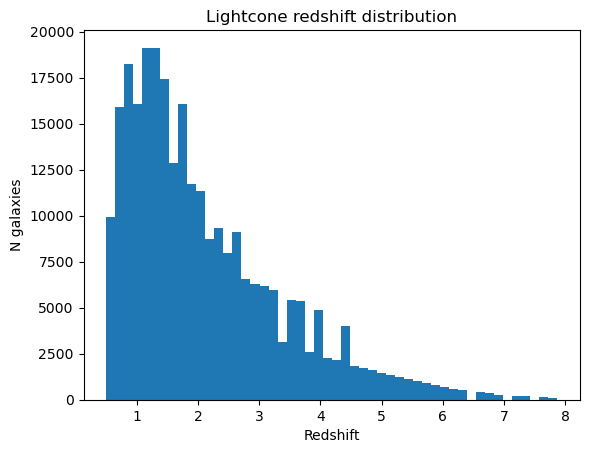

In [2]:
# Generate a lightcone
lc_file = generate_lightcone(
    area_deg2=1.0,  # 1 square degree
    z_min=0.5,
    z_max=8.0,
    output_file=OUTPUT_DIR / "test_lightcone.h5",
    verbose=True
)

# Load and inspect
with h5py.File(lc_file, 'r') as f:
    print("Keys:", list(f.keys()))
    print("N galaxies:", f.attrs['n_galaxies'])
    z = f['z'][:]
    
plt.hist(z, bins=50)
plt.xlabel('Redshift')
plt.ylabel('N galaxies')
plt.title('Lightcone redshift distribution')
plt.show()

In [3]:
from astropy.cosmology import Planck15 as cosmo

for z in [0.0, 0.1, 0.5, 1.0, 2.0, 5.0]:
    L_unit = cosmo.kpc_comoving_per_arcmin(z).to('Mpc / degree')
    A = (L_unit * 1.0**0.5).value  # 1 deg^2
    print(f"z={z}: 1 deg² = {A:.1f} Mpc, box is 50 Mpc, A > box? {A > 50.0}")

z=0.0: 1 deg² = 0.0 Mpc, box is 50 Mpc, A > box? False
z=0.1: 1 deg² = 7.5 Mpc, box is 50 Mpc, A > box? False
z=0.5: 1 deg² = 34.0 Mpc, box is 50 Mpc, A > box? False
z=1.0: 1 deg² = 59.3 Mpc, box is 50 Mpc, A > box? True
z=2.0: 1 deg² = 92.7 Mpc, box is 50 Mpc, A > box? True
z=5.0: 1 deg² = 138.8 Mpc, box is 50 Mpc, A > box? True


In [4]:
# Load the lightcone
with h5py.File(OUTPUT_DIR / "test_lightcone.h5", 'r') as f:
    lc_z = f['z'][:]
    lc_snap = f['snap'][:]
    lc_idx = f['galaxy_index'][:]
    lc_stellar_mass = f['stellar_mass'][:]

print(f"Lightcone has {len(lc_z)} galaxies")

Lightcone has 274208 galaxies


In [5]:
# Function to compute apparent magnitude from absolute magnitude
def abs_to_app_mag(abs_mag, z):
    """Convert absolute magnitude to apparent magnitude at redshift z."""
    d_L = cosmo.luminosity_distance(z).to('pc').value  # in parsecs
    distance_modulus = 5 * np.log10(d_L / 10)  # 10 pc is the reference
    return abs_mag + distance_modulus


def flux_from_mag(mag):
    """Convert AB magnitude to flux (arbitrary units, but consistent)."""
    return 10**(-0.4 * mag)


def mag_from_flux(flux):
    """Convert flux back to AB magnitude."""
    return -2.5 * np.log10(flux)

In [6]:
# Now loop through lightcone galaxies and compute SEDs
# Group by snapshot to avoid reloading Caesar files

from collections import defaultdict

# Group galaxies by snapshot
snap_groups = defaultdict(list)
for i, (snap, idx, z) in enumerate(zip(lc_snap, lc_idx, lc_z)):
    snap_groups[snap].append((i, idx, z))

print(f"Galaxies spread across {len(snap_groups)} snapshots")

Galaxies spread across 99 snapshots


In [7]:
from astropy.cosmology import Planck15 as cosmo

# Initialize FSPS
sp = fsps.StellarPopulation(
    zcontinuous=1,
    sfh=0,  # SSP
    logzsol=0.0,
    dust_type=2,
)

# Get wavelength grid
wave = sp.wavelengths  # Angstroms

# Store all apparent-magnitude SEDs
all_app_seds = []  # List of (wavelength, flux) for each galaxy

for snap_num in sorted(snap_groups.keys()):
    galaxies_in_snap = snap_groups[snap_num]
    
    # Load Caesar catalogue for this snapshot
    cat_path = CAT_DIR / f"m50n512_{snap_num:03d}.hdf5"
    obj = caesar.load(str(cat_path))
    
    print(f"Processing snap {snap_num}: {len(galaxies_in_snap)} galaxies")
    
    for lc_i, gal_idx, gal_z in galaxies_in_snap:
        gal = obj.galaxies[gal_idx]
        
        # Get galaxy properties for FSPS
        stellar_mass = gal.masses['stellar'].value  # Solar masses
        metallicity = gal.metallicities['stellar']  # Mass-weighted Z
        
        # Simple approach: use mass-weighted age
        # (You might have a more sophisticated method from previous weeks)
        age_gyr = cosmo.age(gal_z).value  # Age of universe at this z
        
        # Set FSPS parameters
        sp.params['logzsol'] = np.log10(metallicity / 0.0142)  # Solar Z = 0.0142
        sp.params['tage'] = age_gyr
        
        # Get absolute magnitude SED (AB mags)
        mags_abs = sp.get_mags(bands=None)  # Returns spectrum in AB mags
        
        # Actually, get the spectrum in Lsun/Hz, then convert
        # sp.get_spectrum() returns (wave, spec) where spec is Lsun/Hz
        wave, spec_Lsun_Hz = sp.get_spectrum(tage=age_gyr)
        
        # Scale by stellar mass (FSPS assumes 1 Msun)
        spec_Lsun_Hz *= stellar_mass
        
        # Convert Lsun/Hz to flux at observer (erg/s/cm²/Hz)
        d_L = cosmo.luminosity_distance(gal_z).to('cm').value
        Lsun_erg_s = 3.828e33  # erg/s
        spec_flux = spec_Lsun_Hz * Lsun_erg_s / (4 * np.pi * d_L**2)
        
        # Apply redshift to wavelengths
        wave_observed = wave * (1 + gal_z)
        
        all_app_seds.append((wave_observed, spec_flux, gal_z))

print(f"Computed SEDs for {len(all_app_seds)} galaxies")

yt : [INFO     ] 2026-01-31 15:42:06,899 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_026.hdf5
yt : [INFO     ] 2026-01-31 15:42:06,944 Found 5865 halos
yt : [INFO     ] 2026-01-31 15:42:07,198 Found 103 galaxies


Processing snap 26: 103 galaxies


yt : [INFO     ] 2026-01-31 15:43:45,477 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_027.hdf5
yt : [INFO     ] 2026-01-31 15:43:45,545 Found 7017 halos
yt : [INFO     ] 2026-01-31 15:43:45,598 Found 142 galaxies


Processing snap 27: 142 galaxies


yt : [INFO     ] 2026-01-31 15:44:10,637 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_028.hdf5
yt : [INFO     ] 2026-01-31 15:44:10,712 Found 8279 halos
yt : [INFO     ] 2026-01-31 15:44:10,881 Found 192 galaxies


Processing snap 28: 192 galaxies


yt : [INFO     ] 2026-01-31 15:45:03,587 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_029.hdf5
yt : [INFO     ] 2026-01-31 15:45:03,838 Found 9652 halos
yt : [INFO     ] 2026-01-31 15:45:03,917 Found 227 galaxies


Processing snap 29: 227 galaxies


yt : [INFO     ] 2026-01-31 15:45:43,936 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_030.hdf5
yt : [INFO     ] 2026-01-31 15:45:44,222 Found 11129 halos
yt : [INFO     ] 2026-01-31 15:45:44,357 Found 273 galaxies


Processing snap 30: 273 galaxies


yt : [INFO     ] 2026-01-31 15:46:32,485 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_031.hdf5
yt : [INFO     ] 2026-01-31 15:46:32,766 Found 12805 halos
yt : [INFO     ] 2026-01-31 15:46:32,941 Found 344 galaxies


Processing snap 31: 344 galaxies


yt : [INFO     ] 2026-01-31 15:47:33,567 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_032.hdf5
yt : [INFO     ] 2026-01-31 15:47:33,906 Found 14657 halos
yt : [INFO     ] 2026-01-31 15:47:33,993 Found 425 galaxies


Processing snap 32: 425 galaxies


yt : [INFO     ] 2026-01-31 15:48:49,316 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_033.hdf5
yt : [INFO     ] 2026-01-31 15:48:49,758 Found 16499 halos
yt : [INFO     ] 2026-01-31 15:48:49,867 Found 517 galaxies


Processing snap 33: 517 galaxies


yt : [INFO     ] 2026-01-31 15:50:20,937 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_034.hdf5
yt : [INFO     ] 2026-01-31 15:50:21,219 Found 18398 halos
yt : [INFO     ] 2026-01-31 15:50:21,371 Found 604 galaxies


Processing snap 34: 604 galaxies


yt : [INFO     ] 2026-01-31 15:52:08,050 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_035.hdf5
yt : [INFO     ] 2026-01-31 15:52:08,422 Found 20183 halos
yt : [INFO     ] 2026-01-31 15:52:08,526 Found 710 galaxies


Processing snap 35: 710 galaxies


yt : [INFO     ] 2026-01-31 15:54:13,730 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_036.hdf5
yt : [INFO     ] 2026-01-31 15:54:14,122 Found 22120 halos
yt : [INFO     ] 2026-01-31 15:54:14,240 Found 808 galaxies


Processing snap 36: 808 galaxies


yt : [INFO     ] 2026-01-31 15:56:36,631 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_037.hdf5
yt : [INFO     ] 2026-01-31 15:56:37,038 Found 24179 halos
yt : [INFO     ] 2026-01-31 15:56:37,236 Found 909 galaxies


Processing snap 37: 909 galaxies


yt : [INFO     ] 2026-01-31 15:59:38,012 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_038.hdf5
yt : [INFO     ] 2026-01-31 15:59:38,549 Found 26276 halos
yt : [INFO     ] 2026-01-31 15:59:38,694 Found 1005 galaxies


Processing snap 38: 1005 galaxies


yt : [INFO     ] 2026-01-31 16:02:35,753 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_039.hdf5
yt : [INFO     ] 2026-01-31 16:02:36,136 Found 28172 halos
yt : [INFO     ] 2026-01-31 16:02:36,347 Found 1102 galaxies


Processing snap 39: 1102 galaxies


yt : [INFO     ] 2026-01-31 16:05:50,662 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_040.hdf5
yt : [INFO     ] 2026-01-31 16:05:51,098 Found 30292 halos
yt : [INFO     ] 2026-01-31 16:05:51,262 Found 1218 galaxies


Processing snap 40: 1218 galaxies


yt : [INFO     ] 2026-01-31 16:09:25,892 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_041.hdf5
yt : [INFO     ] 2026-01-31 16:09:26,233 Found 32326 halos
yt : [INFO     ] 2026-01-31 16:09:26,536 Found 1329 galaxies


Processing snap 41: 1329 galaxies


yt : [INFO     ] 2026-01-31 16:13:21,412 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_042.hdf5
yt : [INFO     ] 2026-01-31 16:13:21,795 Found 34308 halos
yt : [INFO     ] 2026-01-31 16:13:22,058 Found 1456 galaxies


Processing snap 42: 1456 galaxies


yt : [INFO     ] 2026-01-31 16:18:05,920 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_043.hdf5
yt : [INFO     ] 2026-01-31 16:18:06,465 Found 36426 halos
yt : [INFO     ] 2026-01-31 16:18:06,595 Found 1595 galaxies


Processing snap 43: 1595 galaxies


yt : [INFO     ] 2026-01-31 16:22:47,958 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_044.hdf5
yt : [INFO     ] 2026-01-31 16:22:48,507 Found 38412 halos
yt : [INFO     ] 2026-01-31 16:22:48,669 Found 1700 galaxies


Processing snap 44: 1700 galaxies


yt : [INFO     ] 2026-01-31 16:27:49,010 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_045.hdf5
yt : [INFO     ] 2026-01-31 16:27:49,237 Found 40177 halos
yt : [INFO     ] 2026-01-31 16:27:49,502 Found 1838 galaxies


Processing snap 45: 1838 galaxies


yt : [INFO     ] 2026-01-31 16:33:13,392 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_046.hdf5
yt : [INFO     ] 2026-01-31 16:33:13,784 Found 41984 halos
yt : [INFO     ] 2026-01-31 16:33:14,044 Found 1926 galaxies


Processing snap 46: 1926 galaxies


yt : [INFO     ] 2026-01-31 16:38:53,351 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_047.hdf5
yt : [INFO     ] 2026-01-31 16:38:53,937 Found 43937 halos
yt : [INFO     ] 2026-01-31 16:38:54,076 Found 2063 galaxies


Processing snap 47: 2063 galaxies


yt : [INFO     ] 2026-01-31 16:45:18,243 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_048.hdf5
yt : [INFO     ] 2026-01-31 16:45:19,058 Found 45557 halos
yt : [INFO     ] 2026-01-31 16:45:19,652 Found 2178 galaxies


Processing snap 48: 2178 galaxies


yt : [INFO     ] 2026-01-31 16:51:43,635 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_049.hdf5
yt : [INFO     ] 2026-01-31 16:51:44,243 Found 47199 halos
yt : [INFO     ] 2026-01-31 16:51:44,378 Found 2272 galaxies


Processing snap 49: 2272 galaxies


yt : [INFO     ] 2026-01-31 16:58:24,496 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_050.hdf5
yt : [INFO     ] 2026-01-31 16:58:25,198 Found 48604 halos
yt : [INFO     ] 2026-01-31 16:58:25,359 Found 2379 galaxies


Processing snap 50: 2379 galaxies


yt : [INFO     ] 2026-01-31 17:05:24,227 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_051.hdf5
yt : [INFO     ] 2026-01-31 17:05:24,790 Found 50250 halos
yt : [INFO     ] 2026-01-31 17:05:25,017 Found 2505 galaxies


Processing snap 51: 2505 galaxies


yt : [INFO     ] 2026-01-31 17:12:46,056 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_052.hdf5
yt : [INFO     ] 2026-01-31 17:12:46,559 Found 51717 halos
yt : [INFO     ] 2026-01-31 17:12:46,807 Found 2575 galaxies


Processing snap 52: 2575 galaxies


yt : [INFO     ] 2026-01-31 17:20:20,022 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_053.hdf5
yt : [INFO     ] 2026-01-31 17:20:20,505 Found 53007 halos
yt : [INFO     ] 2026-01-31 17:20:20,779 Found 2665 galaxies


Processing snap 53: 2665 galaxies


yt : [INFO     ] 2026-01-31 17:28:28,903 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_054.hdf5
yt : [INFO     ] 2026-01-31 17:28:29,627 Found 54202 halos
yt : [INFO     ] 2026-01-31 17:28:29,843 Found 2710 galaxies


Processing snap 54: 2710 galaxies


yt : [INFO     ] 2026-01-31 17:36:26,716 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_055.hdf5
yt : [INFO     ] 2026-01-31 17:36:27,195 Found 55418 halos
yt : [INFO     ] 2026-01-31 17:36:27,359 Found 2819 galaxies


Processing snap 55: 2819 galaxies


yt : [INFO     ] 2026-01-31 17:44:43,356 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_056.hdf5
yt : [INFO     ] 2026-01-31 17:44:44,059 Found 56378 halos
yt : [INFO     ] 2026-01-31 17:44:44,396 Found 2873 galaxies


Processing snap 56: 2873 galaxies


yt : [INFO     ] 2026-01-31 17:53:10,049 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_057.hdf5
yt : [INFO     ] 2026-01-31 17:53:10,660 Found 57510 halos
yt : [INFO     ] 2026-01-31 17:53:10,898 Found 2898 galaxies


Processing snap 57: 2898 galaxies


yt : [INFO     ] 2026-01-31 18:01:42,950 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_058.hdf5
yt : [INFO     ] 2026-01-31 18:01:43,800 Found 58558 halos
yt : [INFO     ] 2026-01-31 18:01:43,968 Found 2963 galaxies


Processing snap 58: 2963 galaxies


yt : [INFO     ] 2026-01-31 18:10:25,854 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_059.hdf5
yt : [INFO     ] 2026-01-31 18:10:26,439 Found 59401 halos
yt : [INFO     ] 2026-01-31 18:10:26,766 Found 3022 galaxies


Processing snap 59: 3022 galaxies


yt : [INFO     ] 2026-01-31 18:19:21,494 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_060.hdf5
yt : [INFO     ] 2026-01-31 18:19:22,058 Found 60256 halos
yt : [INFO     ] 2026-01-31 18:19:22,321 Found 3065 galaxies


Processing snap 60: 3065 galaxies


yt : [INFO     ] 2026-01-31 18:28:24,109 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_061.hdf5
yt : [INFO     ] 2026-01-31 18:28:24,799 Found 60973 halos
yt : [INFO     ] 2026-01-31 18:28:25,017 Found 3097 galaxies


Processing snap 61: 3097 galaxies


yt : [INFO     ] 2026-01-31 18:37:31,864 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_062.hdf5
yt : [INFO     ] 2026-01-31 18:37:32,343 Found 61816 halos
yt : [INFO     ] 2026-01-31 18:37:32,745 Found 3109 galaxies


Processing snap 62: 3109 galaxies


yt : [INFO     ] 2026-01-31 18:46:41,306 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_063.hdf5
yt : [INFO     ] 2026-01-31 18:46:42,273 Found 62486 halos
yt : [INFO     ] 2026-01-31 18:46:42,569 Found 3180 galaxies


Processing snap 63: 3180 galaxies


yt : [INFO     ] 2026-01-31 18:56:03,556 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_064.hdf5
yt : [INFO     ] 2026-01-31 18:56:04,177 Found 62958 halos
yt : [INFO     ] 2026-01-31 18:56:04,428 Found 3249 galaxies


Processing snap 64: 3249 galaxies


yt : [INFO     ] 2026-01-31 19:05:38,004 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_065.hdf5
yt : [INFO     ] 2026-01-31 19:05:38,614 Found 63584 halos
yt : [INFO     ] 2026-01-31 19:05:38,921 Found 3287 galaxies


Processing snap 65: 3287 galaxies


yt : [INFO     ] 2026-01-31 19:15:18,953 Opening /home/spujni/sim/m50n512/s50/Groups/m50n512_066.hdf5
yt : [INFO     ] 2026-01-31 19:15:19,439 Found 64132 halos
yt : [INFO     ] 2026-01-31 19:15:19,754 Found 3351 galaxies


Processing snap 66: 3351 galaxies


KeyboardInterrupt: 

In [1]:
# Now sum all SEDs onto a common wavelength grid
# Need to interpolate since each galaxy has different observed wavelengths

# Define common observed wavelength grid
wave_common = np.logspace(np.log10(1000), np.log10(50000), 500)  # 1000 Å to 5 μm

total_flux = np.zeros_like(wave_common)

for wave_obs, flux, z in all_app_seds:
    # Interpolate onto common grid
    flux_interp = np.interp(wave_common, wave_obs, flux, left=0, right=0)
    total_flux += flux_interp

# Convert to surface brightness (per steradian)
# 1 deg² = (π/180)² steradians
area_sr = (1.0 * np.pi / 180)**2  # 1 deg² in steradians
surface_brightness = total_flux / area_sr  # erg/s/cm²/Hz/sr

# Plot the cosmic SED
plt.figure(figsize=(10, 6))
plt.loglog(wave_common, surface_brightness * wave_common)  # νIν or λIλ
plt.xlabel('Observed Wavelength (Å)')
plt.ylabel(r'$\lambda I_\lambda$ (erg/s/cm²/sr)')
plt.title('Cosmic Optical/IR Background from Lightcone')
plt.xlim(1000, 50000)
plt.show()

NameError: name 'np' is not defined